return [1, 1, 1, 1, 1, 1, 20, 6, 1, 161] 

for the values 6 is for R_arm, L_arm etc., 20 is for p values, initial conditions for x, angular frequency, time  
        
We need

* Six individual parameters (R_arm, L_arm, etc.)

* 1 array of size 20 for p

* 1 array of size 6 for initial conditions for x_1:6

* One angular frequency (omega)

* 1 array off size 151 for time interval (T)

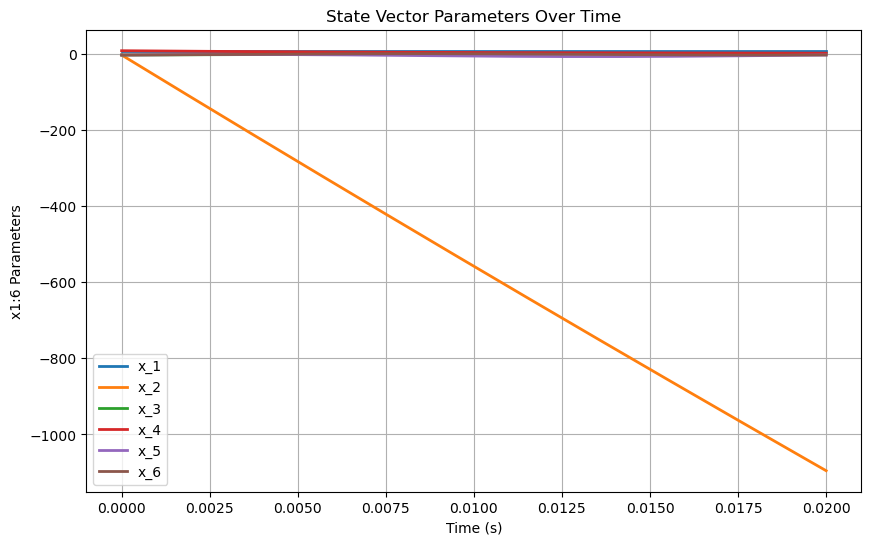

In [35]:
import umbridge
import numpy as np

# Initialize the model
model = umbridge.HTTPModel("http://localhost:4242", "forward")

R_arm = [ 20e-3 ]     # Example value for R_arm
R_DC = [10e-3]      # Example value for R_DC
R_AC = [60e-3 ]      # Example value for R_AC
L_arm = [200e-6]     # Example value for L_arm
L_DC = [5e-3]      # Example value for L_DC
L_AC = [320e-3]      # Example value for L_AC

p = [0,0,0,0,350,330,50,23.3/2,0,50,0,23.3/2,50,0,427.5/2,0,50,0,427.5/2,50,0,100.7/2,0,50,0,100.7/2,50,0,676.7/2,0,50,0,676.7/2,50,0,272.5/2,0,50,0,272.5/2,50,0]

x_initial = [7.5, -3.75, -3.75,  7.5,  -3.75, -3.75]      # Example initial conditions for x (size 6)
omega = [2*np.pi*50]                  # Example angular frequency
resolution = 125e-6
T = [0.02]   
T_eval = [t for t in np.arange(0, T[0] + resolution, resolution)]

#phase shift = u0  120u1=u4 240u2=u5  u3 330amplitude=p[16] p15=-350  

# Create the parameters list
parameters = [R_arm, R_DC, R_AC, L_arm, L_DC, L_AC, p, x_initial, omega, T_eval]

#Call the model
result = model(parameters)
result = np.array(result)
x_1 = np.array(result[0])
x_2 = np.array(result[1])
x_3 = np.array(result[2])
x_4 = np.array(result[3])
x_5 = np.array(result[4])
x_6 = np.array(result[5])


plt.figure(figsize=(10, 6))

# Plot each control vector (u1 to u6)
plt.plot(T_eval, x_1, label='x_1', linewidth=2)
plt.plot(T_eval, x_2, label='x_2', linewidth=2)
plt.plot(T_eval, x_3, label='x_3', linewidth=2)
plt.plot(T_eval, x_4, label='x_4', linewidth=2)
plt.plot(T_eval, x_5, label='x_5', linewidth=2)
plt.plot(T_eval, x_6, label='x_6', linewidth=2)

# Add labels and title
plt.xlabel('Time (s)')
plt.ylabel('x1:6 Parameters')
plt.title('State Vector Parameters Over Time')
plt.legend()  # Show legend
plt.grid(True)  # Add grid
plt.show()  # Display the plot



The following code is used for solving the 2nd equation (3b in the paper), so that we get the solutions for $x_7,x_8,x_9,x_{10},x_{11},x_{12}$ and also we use the following u functions 


$$
\begin{align}
u_1(t) &= p_0 + p_1 \sin(2\pi p_2 t) + p_3 \cos(2\pi p_4 t) \\
u_2(t) &= p_5 + p_6 \sin(2\pi p_7 t) + p_8 \cos(2\pi p_9 t) \\
...
\end{align}
$$
The plot can be seen below. 

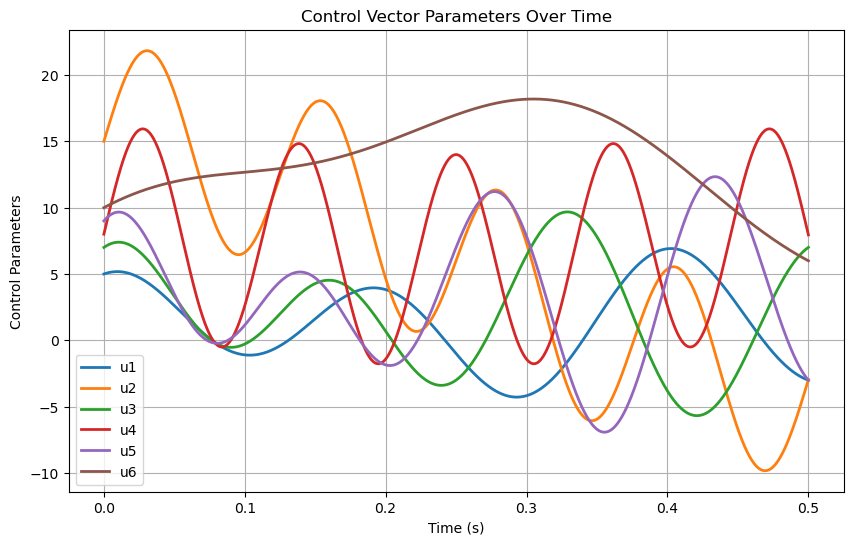

In [28]:
import numpy as np
import matplotlib.pyplot as plt

resolution = 125e-6
T = [0.5]
T_eval = [t for t in np.arange(0, T[0] + resolution, resolution)]
p = [1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3]

def control_vector_egal(t, p):
    u = [0] * 6  # Initialize u as a list with 6 elements
    u[0] = p[0] + p[1]*np.sin(2*np.pi*p[2]*t) + p[3]*np.cos(2*np.pi*p[4]*t)
    u[1] = p[5] + p[6]*np.sin(2*np.pi*p[7]*t) + p[8]*np.cos(2*np.pi*p[9]*t)
    u[2] = p[10] + p[11]*np.sin(2*np.pi*p[12]*t) + p[13]*np.cos(2*np.pi*p[14]*t)
    u[3] = p[15] + p[16]*np.sin(2*np.pi*p[17]*t) + p[18]*np.cos(2*np.pi*p[19]*t)
    u[4] = p[20] + p[21]*np.sin(2*np.pi*p[22]*t) + p[23]*np.cos(2*np.pi*p[24]*t)
    u[5] = p[25] + p[26]*np.sin(2*np.pi*p[27]*t) + p[28]*np.cos(2*np.pi*p[29]*t)
    
    return u  # Convert to array if needed

control_vectors = []

# Example of how to use the function
for t in T_eval:
    control_vector = control_vector_egal(t, p)
    control_vectors.append(control_vector)

# Convert the list of control vectors to a numpy array
control_vectors_array = np.array(control_vectors)
control_vectors_array_T = np.transpose(control_vectors_array)

# Extract each parameter as a separate array (column-wise)
u1 = control_vectors_array[:, 0]  # First column (u1)
u2 = control_vectors_array[:, 1]  # Second column (u2)
u3 = control_vectors_array[:, 2]  # Third column (u3)
u4 = control_vectors_array[:, 3]  # Fourth column (u4)
u5 = control_vectors_array[:, 4]  # Fifth column (u5)
u6 = control_vectors_array[:, 5]  # Sixth column (u6)


plt.figure(figsize=(10, 6))

# Plot each control vector (u1 to u6)
plt.plot(T_eval, u1, label='u1', linewidth=2)
plt.plot(T_eval, u2, label='u2', linewidth=2)
plt.plot(T_eval, u3, label='u3', linewidth=2)
plt.plot(T_eval, u4, label='u4', linewidth=2)
plt.plot(T_eval, u5, label='u5', linewidth=2)
plt.plot(T_eval, u6, label='u6', linewidth=2)

# Add labels and title
plt.xlabel('Time (s)')
plt.ylabel('Control Parameters')
plt.title('Control Vector Parameters Over Time')
plt.legend()  # Show legend
plt.grid(True)  # Add grid
plt.show()  # Display the plot

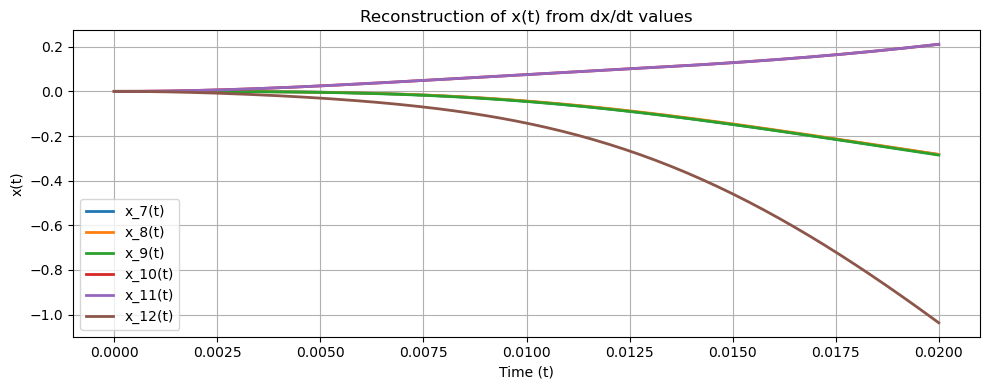

In [23]:
from scipy.integrate import odeint

# T matrix 
matrix_T = np.array( [[1/np.sqrt(6), 1/np.sqrt(6), 1/np.sqrt(6), 1/np.sqrt(6), 1/np.sqrt(6), 1/np.sqrt(6)],
                      [-1/np.sqrt(6), -1/np.sqrt(6), -1/np.sqrt(6), 1/np.sqrt(6), 1/np.sqrt(6), 1/np.sqrt(6)],
                      [1/2, -1/2, 0, -1/2, 1/2, 0],
                      [1/np.sqrt(12), 1/np.sqrt(12), -1/np.sqrt(3), -1/np.sqrt(12), -1/np.sqrt(12), 1/np.sqrt(3)],
                      [-1/2, 1/2, 0, -1/2, 1/2, 0],
                      [-1/np.sqrt(12), -1/np.sqrt(12), 1/np.sqrt(3), -1/np.sqrt(12), -1/np.sqrt(12), 1/np.sqrt(3)],
                     ])

T_transpose = np.transpose(matrix_T)
dxdt_7_12 = (T_transpose @ control_vectors_array_T) * (T_transpose @ result)
dxdt_7 = dxdt_7_12[0]
dxdt_8 = dxdt_7_12[1]
dxdt_9 = dxdt_7_12[2]
dxdt_10 = dxdt_7_12[3]
dxdt_11 = dxdt_7_12[4]
dxdt_12 = dxdt_7_12[5]

# x_7
x7_0 = 0  # Replace with your specific initial condition
x7_values = np.zeros(len(T_eval))
x7_values[0] = x7_0

for i in range(1, len(T_eval)):
    x7_values[i] = x7_values[i - 1] + dxdt_7[i - 1] * resolution

#x_8
x8_0 = 0  # Replace with your specific initial condition
x8_values = np.zeros(len(T_eval))
x8_values[0] = x8_0

for j in range(1, len(T_eval)):
    x8_values[j] = x7_values[j - 1] + dxdt_8[j - 1] * resolution



#x_9
x9_0 = 0  # Replace with your specific initial condition
x9_values = np.zeros(len(T_eval))
x9_values[0] = x9_0

for k in range(1, len(T_eval)):
    x9_values[k] = x7_values[k - 1] + dxdt_9[k - 1] * resolution


#x_10
x10_0 = 0  # Replace with your specific initial condition
x10_values = np.zeros(len(T_eval))
x10_values[0] = x10_0

for l in range(1, len(T_eval)):
    x10_values[l] = x10_values[l - 1] + dxdt_10[l - 1] * resolution



#x_11
x11_0 = 0  # Replace with your specific initial condition
x11_values = np.zeros(len(T_eval))
x11_values[0] = x11_0

for m in range(1, len(T_eval)):
    x11_values[m] = x10_values[m - 1] + dxdt_10[m - 1] * resolution


#x_12
x12_0 = 0  # Replace with your specific initial condition
x12_values = np.zeros(len(T_eval))
x12_values[0] = x12_0

for n in range(1, len(T_eval)):
    x12_values[n] = x12_values[n - 1] + dxdt_12[n - 1] * resolution




# Plotting the results
plt.figure(figsize=(10, 4))
plt.plot(T_eval, x7_values, label='x_7(t)', linewidth=2)
plt.plot(T_eval, x8_values, label='x_8(t)', linewidth=2)
plt.plot(T_eval, x9_values, label='x_9(t)', linewidth=2)
plt.plot(T_eval, x10_values, label='x_10(t)', linewidth=2)
plt.plot(T_eval, x11_values, label='x_11(t)', linewidth=2)
plt.plot(T_eval, x12_values, label='x_12(t)', linewidth=2)

# Adding labels and title
plt.xlabel('Time (t)')
plt.ylabel('x(t)')
plt.title('Reconstruction of x7:12(t) from dx/dt values')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



This is for the last equation $\tilde{y} = \tilde{C}x_{1:6}$. To find the initial conditions for $x_{1:6}$, we are using the function of $y_{ref}$ at time $t=0$. Then we have the following linear system 

\begin{equation}
\left(\begin{array}{cc} 
y_{1,ref}(0) \\
y_{2,ref}(0) \\
y_{3,ref}(0) \\
\end{array}\right)
= - \left(\begin{array}{c} 
1 & 0 & 0 & 1 & 0 & 0 \\
0 & 1 & 0 & 0 & 1 & 0 \\
0 & 0 & 1 & 0 & 0 & 1 \\
\end{array}\right) 
\left(\begin{array}{c} 
x_1(0) \\
x_2(0) \\
x_3(0) \\
x_4(0) \\
x_5(0) \\
x_6(0) \\
\end{array}\right)  
\end{equation}

Since we dont have square matrix, the equation is under or over determined. By using the least square method, we can estimate the solution.

In [24]:
y_ref = [0] * 3
I_AC = 15
phi_AC = 0
matrix_C = np.array([[1, 0, 0, 1, 0, 0],
              [0, 1, 0, 0, 1, 0],
              [0, 0, 1, 0, 0, 1]])

#print(np.linalg.inv(matrix_C))


def y(T, omega):
        for k in range(1, 4):
            y_ref[k-1]= I_AC * np.cos (omega * T - (2 * np.pi * (k-1))/3 -phi_AC)

        return y_ref

y0_values = y(0, 50)
x0, residuals, rank, s = np.linalg.lstsq(matrix_C, y0_values, rcond=None)
print("initial condition values for x_1 to x_6 using least squares:", x0)

initial condition values for x_1 to x_6 using least squares: [ 7.5  -3.75 -3.75  7.5  -3.75 -3.75]


Now we need to do the transformation 

$$\mathbf{\underline{y}} = (\mathbf{C}^\top)^+ \underline{T}^T \tilde{\underline{C}} \tilde{\underline{\mathbf{x}}}_{1-6} = \begin{bmatrix} -\tilde{x_{5}}-\frac{1}{\sqrt{3}} \tilde{x_{6}}\\ \tilde{x_{5}}-\frac{1}{\sqrt{3}} \tilde{x_{6}}\\ \frac{2}{\sqrt{3}} \tilde{x_{6}} \end{bmatrix}\tag{11c + 11d}$$

In [33]:
def compute_y (x_5, x_6):
    y = np.array([
        -x_5-1/np.sqrt(3)*x_6,
        x_5-1/np.sqrt(3)*x_6,
        2/np.sqrt(3)*x_6
    ])
    return y

y= compute_y(x_5, x_6)

print(y)

[[ 5.91506351  5.7989556   5.68374792  5.56961665  5.45673994  5.34529298
   5.23544773  5.127373    5.02123436  4.9171942   4.81541169  4.71604282
   4.61924036  4.52515388  4.43392977  4.34575984  4.26092824  4.1795534
   4.10173581  4.02757064  3.95714779  3.89055186  3.82786214  3.76915264
   3.71449209  3.66394389  3.61756618  3.57541178  3.53752824  3.5039578
   3.47473741  3.44989872  3.42946809  3.4134666   3.40191001  3.39480881
   3.39216817  3.393988    3.40026289  3.41098213  3.42612975  3.44568445
   3.46961965  3.49790349  3.53049879  3.56736309  3.60844863  3.65370238
   3.70306597  3.75647578  3.81386287  3.87515302  3.9402667   4.00911911
   4.08162012  4.15767435  4.23718109  4.32003435  4.40612285  4.49533001
   4.58753396  4.68260752  4.78041824  4.88082836  4.98369484  5.08886933
   5.19619819  5.30552248  5.416678    5.5294952   5.64379929  5.75941016
   5.87614239  5.99380529  6.11220289  6.23113388  6.35039169  6.46976445
   6.589035    6.70798087  6.8263743   6

In [38]:
try:
    matrix_T_inv = np.linalg.inv(matrix_T)
    print("Inverse of T:")
    print(matrix_T_inv)
except np.linalg.LinAlgError:
    print("Matrix T cannot be inverted.")



tilde_x = np.vstack([x_1, x_2, x_3, x_4, x_5, x_6])

def compute_x(matrix_T_inv, tilde_x):
    """
    Compute x_{1-6} = T^{-1} * \tilde{x}_{1-6}
    
    Args:
    matrix_T_inv (numpy.ndarray): Inverse of the matrix T (6x6)
    tilde_x (numpy.ndarray): The vector \tilde{x}_{1-6} (6xN where N is the number of time steps)
    
    Returns:
    numpy.ndarray: The resulting x_{1-6} (6xN)
    """
    # Perform matrix multiplication: x_{1-6} = T^{-1} * \tilde{x}_{1-6}
    x = np.dot(matrix_T_inv, tilde_x)
    
    return x

print(compute_x(matrix_T_inv, tilde_x))

Inverse of T:
[[ 4.08248290e-01 -4.08248290e-01  5.00000000e-01  2.88675135e-01
  -5.00000000e-01 -2.88675135e-01]
 [ 4.08248290e-01 -4.08248290e-01 -5.00000000e-01  2.88675135e-01
   5.00000000e-01 -2.88675135e-01]
 [ 4.08248290e-01 -4.08248290e-01  3.20493781e-17 -5.77350269e-01
   3.20493781e-17  5.77350269e-01]
 [ 4.08248290e-01  4.08248290e-01 -5.00000000e-01 -2.88675135e-01
  -5.00000000e-01 -2.88675135e-01]
 [ 4.08248290e-01  4.08248290e-01  5.00000000e-01 -2.88675135e-01
   5.00000000e-01 -2.88675135e-01]
 [ 4.08248290e-01  4.08248290e-01  0.00000000e+00  5.77350269e-01
   0.00000000e+00  5.77350269e-01]]
[[   7.84038853   10.65579979   13.47052315   16.28464665   19.0982593
    21.91144862   24.72430056   27.53689948   30.34932812   33.16166765
    35.97399764   38.78639604   41.59893924   44.41170202   47.22475756
    50.03820159   52.85217561   55.6667389    58.48194179   61.29783199
    64.11445456   66.9318519    69.75006378   72.56912732   75.38907699
    78.20994462   81